In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import random
import pandas as pd
from mpmath import mp
from mpl_toolkits import mplot3d
import time 
from tqdm import tqdm 

In [2]:
df = pd.read_csv('all_distributions_samples.csv')
binomial_sample_values = df['binomial_sample'].to_numpy()
geometric_sample_values = df['geometric_sample'].to_numpy()
poisson_sample_values = df['poisson_sample'].to_numpy()
all_dists = ['poisson_sample', 'geometric_sample', 'binomial_sample']
# all_dists = ['geometric_sample']

In [3]:
arr_b = []
arr_p = []
arr_g = []
rew_b = []
def func(s, ss, dist):
    max_ss = max(ss)
    if dist == 'binomial_sample':
        diff_arr = [0,0,0,0]
        for i in range(len(s)):
            diff_arr[i] = ss[i] - s[i]
        for i in range(4):
            if (diff_arr[i] != 0) and s[i] != np.max(s):
                arr_b.append(0)
            else:
                arr_b.append(1)
    elif dist == 'geometric_sample':
        diff_arr = [0,0,0,0]
        for i in range(len(s)):
            diff_arr[i] = ss[i] - s[i]
        for i in range(4):
            if (diff_arr[i] != 0) and s[i] != np.max(s):
                arr_g.append(0)
            else:
                arr_g.append(1)
    elif dist == 'poisson_sample':
        diff_arr = [0,0,0,0]
        for i in range(len(s)):
            diff_arr[i] = ss[i] - s[i]
        for i in range(4):
            if (diff_arr[i] != 0) and s[i] != np.max(s):
                arr_p.append(0)
            else:
                arr_p.append(1)
                

In [4]:
class envir():
    def __init__(self):
        self.phi = 4
        self.S = np.array([1,1,1,1])
    
    def step(self,task,s,jobsize,dist):
        s_old = s[task]
        reward = 0
        
        if(s_old==jobsize[task] or s_old==0):
            s_new = 0
        else:
            s_new = s_old+1
        
        if(s_old==0):
            reward = -5
        elif(s_old!=0 and s_new!=0):
            reward = -0
        else:
            reward = 1

        new_state = [0,0,0,0]
        for i in range(4):
            if i==task:
                new_state[i] = s_new
            else:
                new_state[i] = s[i]
        func(s, new_state, dist)
        # print(reward)
        return new_state,reward

    def getjob(self, dist, job_counter):
        
        if dist == 'binomial_sample':
            ret = binomial_sample_values[job_counter * 4 : job_counter * 4 + 4]
             
        elif dist == 'geometric_sample':
            ret = geometric_sample_values[job_counter * 4 : job_counter * 4 + 4]
        
        elif dist == 'poisson_sample':
            ret = poisson_sample_values[job_counter * 4 : job_counter * 4 + 4]
            
        return ret
    

In [5]:
class Agent():
    def __init__(self,alpha,gamma,T):
        self.Q_values = np.zeros((6,2,6))
        self.phi = 4
        self.S = np.array([6,6,6,6])
        self.alpha = alpha
        self.T = T
        self.gamma = gamma
    def activate_task(self,s):
        summ = 0
        for i in range(4):
            if s[i]!=0:
                summ += mp.exp((self.Q_values[s[i]][0][s[i]])/self.T)
        
        prob = []
        for i in range(4):
            num = mp.exp((self.Q_values[s[i]][0][s[i]])/self.T)
            if(s[i]==0):
                num = 0
            prob.append(num/summ)
        task = random.choice(4,1,p=prob)
        return task[0]


    def act_greedy(self,ns,restart_prob,task):
        return max((self.Q_values[ns[task]][0][restart_prob]),(self.Q_values[ns[task]][1][restart_prob]))

    def update(self,s,next_state,reward,task):
        for k in range(6):
            self.Q_values[s[task]][0][k] = (1-self.alpha)*(self.Q_values[s[task]][0][k]) + self.alpha*(reward+self.gamma*(self.act_greedy(next_state,k,task)))
            self.Q_values[k][1][s[task]] = (1-self.alpha)*(self.Q_values[k][1][s[task]]) + self.alpha*(reward+self.gamma*(self.act_greedy(next_state,s[task],task)))
    
    def testing(self,s):
        maxe = 0
        ind = 0
        for i in range(4):
            maxe = max(self.Q_values[s[i]][0][s[i]],maxe)
        for i in range(4):
            if(self.Q_values[s[i]][0][s[i]]==maxe):
                ind = i
        return ind

In [6]:
def calculate_count(service, size, new_service):
    count = 0
    count2 = 0
    max_value = np.max(service)
    flag = 0
    count_max = np.sum(service == max_value)
    if count_max == 1:
        for i in range(4):
            if np.argmax(service) == i:
                if service[i]+1 == new_service[i] or new_service[i] == 0:
                    count += 0
                else:
                    count += 1
    else:
        for i in range(4):
            if np.max(service) == service[i]:
                if service[i]+1 == new_service[i] or new_service[i] == 0:
                    flag = 1
        if flag == 0:
            count += 1
    return count

100%|███████████████████████████████████| 20000/20000 [00:10<00:00, 1930.52it/s]


[1 1 1 1]


100%|███████████████████████████████████| 20000/20000 [00:06<00:00, 2988.38it/s]


[1 1 1 1]


100%|███████████████████████████████████| 20000/20000 [00:16<00:00, 1202.17it/s]


[3 3 2 3]


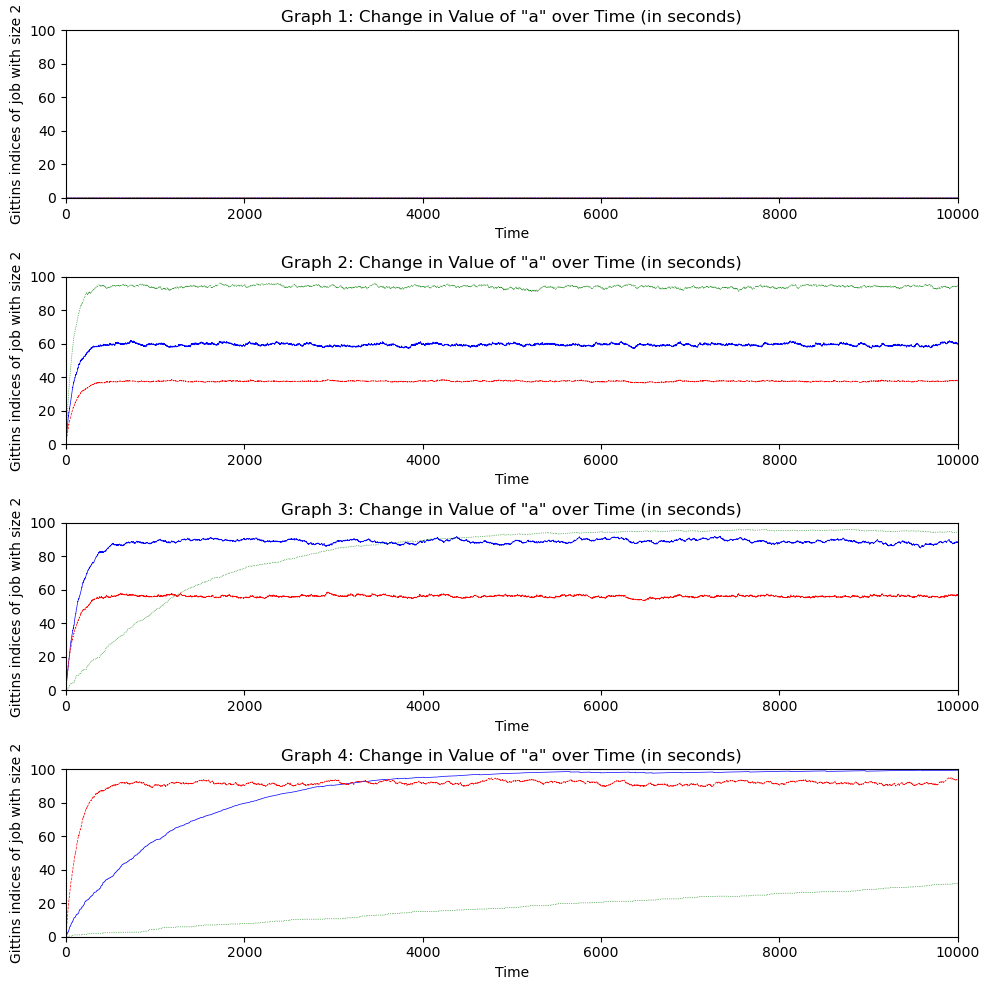

In [7]:
ans = np.zeros((6,4))
time_points_g = []
a_values_g = [ []*2 for i in range(4)]
time_points_b = []
a_values_b = [ []*2 for i in range(4)]
time_points_p = []
a_values_p = [ []*2 for i in range(4)]
regret_arr_b = []
regret_arr_g = []
regret_arr_p = []
def pull():
    for dist in all_dists:
        start_time = time.time()
        env = envir()
        agent = Agent(alpha=0.3,gamma=0.99,T=75000)
        trials = 20000
        agent.alpha = 0.3
        agent.gamma = 0.99
        agent.T = 75000
        Tmax = 75000
        Tmin = 0.25
        phi = 4
        job_counter = 0
        for trial_no in tqdm(range(trials)):
            jobsize = env.getjob(dist,job_counter)
            s = np.array([1,1,1,1])
            count = 0
            regret_sum = 0
            while(s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0):
                    arm = agent.activate_task(s)
                    action = arm
                    s_curr = s.copy()
                    next_state,reward = env.step(arm,s,jobsize,dist)
                    agent.update(s_curr,next_state,reward,arm)
                    counter = calculate_count(s, jobsize, next_state)
                    regret_sum += counter
                    s = next_state
                    current_time = time.time() - start_time
            if dist == 'binomial_sample':
                time_points_b.append(current_time)
                a_values_b[0].append(agent.Q_values[0][0][0])
                a_values_b[1].append(agent.Q_values[1][0][1])
                a_values_b[2].append(agent.Q_values[2][0][2])
                a_values_b[3].append(agent.Q_values[3][0][3])
                regret_arr_b.append(regret_sum)
            elif dist == 'geometric_sample':
                time_points_g.append(current_time)
                a_values_g[0].append(agent.Q_values[0][0][0])
                a_values_g[1].append(agent.Q_values[1][0][1])
                a_values_g[2].append(agent.Q_values[2][0][2])
                a_values_g[3].append(agent.Q_values[3][0][3])
                regret_arr_g.append(regret_sum)
            if dist == 'poisson_sample':
                time_points_p.append(current_time)
                a_values_p[0].append(agent.Q_values[0][0][0])
                a_values_p[1].append(agent.Q_values[1][0][1])
                a_values_p[2].append(agent.Q_values[2][0][2])
                a_values_p[3].append(agent.Q_values[3][0][3])
                regret_arr_p.append(regret_sum)
            agent.T = Tmin + 0.992*(agent.T - Tmin)
            job_counter += 1
        jobsize = env.getjob(dist,job_counter)
        print(jobsize)
        s = np.array([1,1,1,1])
        '''while(s[0]!=0 or s[1]!=0 or s[2]!=0 or s[3]!=0):
            task = agent.testing(s)
            print(s)
            s_curr = s.copy()
            next_state,reward = env.step(task,s,jobsize,dist)
            agent.update(s_curr,next_state,reward,task)
            s = next_state'''
    
    line_styles = ['-', '--', ':']
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))

    for i in range(4):
        axs[i].plot(a_values_p[i], color='blue', linestyle=line_styles[0], linewidth=0.5)
        axs[i].plot(a_values_b[i], color='red', linestyle=line_styles[1], linewidth=0.5)
        axs[i].plot(a_values_g[i], color='green', linestyle=line_styles[2], linewidth=0.5)

        axs[i].set_xlabel('Time')
        axs[i].set_xlim(0, 10000)
        axs[i].set_ylim(0, 100)
        axs[i].set_ylabel('Gittins indices of job with size 2')
        axs[i].set_title(f'Graph {i+1}: Change in Value of "a" over Time (in seconds)')

    plt.tight_layout()
    plt.show()


    
pull()

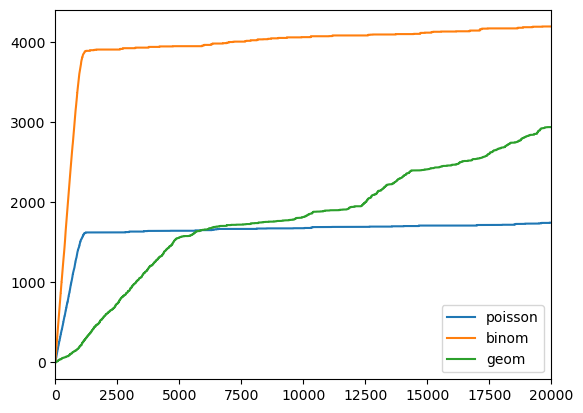

In [8]:
cum_regret_p = []
cum_regret_p.append(regret_arr_p[0])
cum_regret_b = []
cum_regret_b.append(regret_arr_b[0])
cum_regret_g = []
cum_regret_g.append(regret_arr_g[0])
for i in range(1,20000):
    cum_regret_p.append(cum_regret_p[i-1] + regret_arr_p[i])
    cum_regret_b.append(cum_regret_b[i-1] + regret_arr_b[i])
    cum_regret_g.append(cum_regret_g[i-1] + regret_arr_g[i])
plt.plot(cum_regret_p, label = 'poisson')
plt.plot(cum_regret_b, label = 'binom')
plt.plot(cum_regret_g, label = 'geom')
plt.xlim([0, 20000])
plt.legend()
plt.show()

In [9]:
# a_values_g
df_g = pd.DataFrame(np.transpose(a_values_g), columns =['Restart_G_0', 'Restart_G_1', 'Restart_G_2', 'Restart_G_3'])
df_g.tail()
# a_values_b
# a_values_p

,Restart_G_0,Restart_G_1,Restart_G_2,Restart_G_3
19995,0.0,92.908988,95.355152,54.472802
19996,0.0,92.997417,95.355152,54.472802
19997,0.0,93.081964,95.355152,54.472802
19998,0.0,93.164822,95.355152,54.472802
19999,0.0,92.949482,95.369087,54.472802


<function matplotlib.pyplot.show(close=None, block=None)>

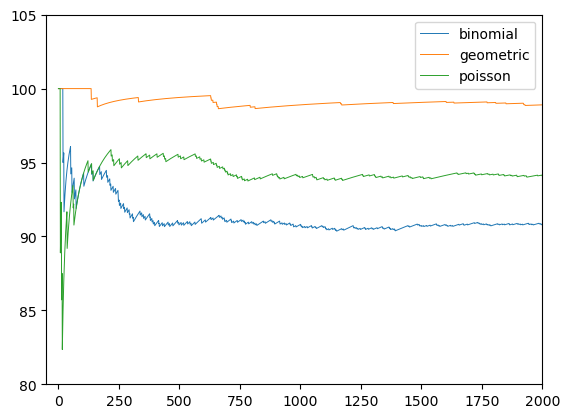

In [14]:
def calculate_percentage(array):
    percentages = []
    cumulative_sum = 0

    for i, value in enumerate(array):
        cumulative_sum += value
        if i == 0:
            percentage = 100 if value == 1 else 0
        else:
            percentage = (cumulative_sum / (i + 1)) * 100
        percentages.append(percentage)

    return percentages

percentages_b = calculate_percentage(arr_b)
percentages_g = calculate_percentage(arr_g)
percentages_p = calculate_percentage(arr_p)
plt.plot(percentages_b, linewidth=0.7, label = 'binomial')
plt.plot(percentages_g, linewidth=0.7, label = 'geometric')
plt.plot(percentages_p, linewidth=0.7, label = 'poisson')
plt.xlim([-50, 2000])
plt.ylim([80, 105])
plt.legend()
plt.show


In [21]:
df_per_b = pd.DataFrame(np.transpose(percentages_b), columns =['Restart_B_Per'])
df_per_g = pd.DataFrame(np.transpose(percentages_g), columns =['Restart_G_Per'])
df_per_p = pd.DataFrame(np.transpose(percentages_p), columns =['Restart_P_Per'])

In [22]:
df_p = pd.DataFrame(np.transpose(a_values_p), columns =['Restart_P_0', 'Restart_P_1', 'Restart_P_2', 'Restart_P_3'])
df_p.tail()

,Restart_P_0,Restart_P_1,Restart_P_2,Restart_P_3
19995,0.0,59.906399,89.495300,98.346178
19996,0.0,59.842518,89.290031,98.351141
19997,0.0,60.092136,89.325287,98.351141
19998,0.0,60.023696,89.392953,98.351141
19999,0.0,60.258590,89.425846,98.351141


In [23]:
df_b = pd.DataFrame(np.transpose(a_values_b), columns =['Restart_B_0', 'Restart_B_1', 'Restart_B_2', 'Restart_B_3'])
df_b.tail()

,Restart_B_0,Restart_B_1,Restart_B_2,Restart_B_3
19995,0.0,37.672431,56.260138,92.449020
19996,0.0,37.575057,55.978705,92.543101
19997,0.0,37.498538,56.066455,92.610819
19998,0.0,37.485736,55.873024,92.399366
19999,0.0,37.455285,55.806937,92.472445


In [24]:
df_cum_regret_p = pd.DataFrame(np.transpose(cum_regret_p), columns =['Restart_Reg_P'])
df_cum_regret_b = pd.DataFrame(np.transpose(cum_regret_b), columns =['Restart_Reg_B'])
df_cum_regret_g = pd.DataFrame(np.transpose(cum_regret_g), columns =['Restart_Reg_G'])

In [25]:
result_df = pd.concat([df_b, df_p, df_g, df_per_b, df_per_g,df_per_p, df_cum_regret_p, df_cum_regret_b, df_cum_regret_g], axis=1, join='inner')
result_df.tail()

,Restart_B_0,Restart_B_1,Restart_B_2,Restart_B_3,Restart_P_0,Restart_P_1,Restart_P_2,Restart_P_3,Restart_G_0,Restart_G_1,Restart_G_2,Restart_G_3,Restart_B_Per,Restart_G_Per,Restart_P_Per,Restart_Reg_P,Restart_Reg_B,Restart_Reg_G
19995,0.0,37.672431,56.260138,92.449020,0.0,59.906399,89.495300,98.346178,0.0,92.908988,95.355152,54.472802,90.718144,98.604721,94.118824,1745,4194,2938
19996,0.0,37.575057,55.978705,92.543101,0.0,59.842518,89.290031,98.351141,0.0,92.997417,95.355152,54.472802,90.718608,98.604791,94.119118,1745,4194,2938
19997,0.0,37.498538,56.066455,92.610819,0.0,60.092136,89.325287,98.351141,0.0,93.081964,95.355152,54.472802,90.719072,98.604860,94.119412,1745,4194,2938
19998,0.0,37.485736,55.873024,92.399366,0.0,60.023696,89.392953,98.351141,0.0,93.164822,95.355152,54.472802,90.719536,98.599930,94.119706,1745,4194,2938
19999,0.0,37.455285,55.806937,92.472445,0.0,60.258590,89.425846,98.351141,0.0,92.949482,95.369087,54.472802,90.720000,98.600000,94.120000,1745,4194,2938


In [26]:
result_df.to_csv('./restart.csv')